In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import graphlab as gl
from graphlab.toolkits.feature_engineering import TFIDF, FeatureHasher, QuadraticFeatures

gl.canvas.set_target('ipynb')

PATH_TO_JSON2 = "docs_prod_02/"
PATH_TO_JSON = "docs_prod_03/"
PATH_TO_TRAIN_LABELS = "input/train.csv"
PATH_TO_TEST_LABELS = "input/sampleSubmission.csv"

[WARNING] This Python session does not appear to be running in an interactive IPython Notebook. Use of the 'ipynb' target may behave unexpectedly or result in errors.


### Read processed documents

In [5]:
gl.set_runtime_config('GRAPHLAB_DEFAULT_NUM_PYLAMBDA_WORKERS', 32)

In [2]:
# documents
sf = gl.SFrame.read_csv(PATH_TO_JSON, header=False, verbose=False)
sf = sf.unpack('X1',column_name_prefix='')
sf['id'] = sf['id'].apply(lambda x: str(x.split('_')[0] ))

sf2 = gl.SFrame.read_csv(PATH_TO_JSON2, header=False, verbose=False)
sf2 = sf2.unpack('X1',column_name_prefix='')
sf2['id'] = sf2['id'].apply(lambda x: str(x.split('_')[0] ))

[INFO] This trial license of GraphLab Create is assigned to renatbek@gmail.com and will expire on October 08, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-6405 - Server binary: /usr/local/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1442647186.log
[INFO] GraphLab Server Version: 1.5.2


------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/20
PROGRESS: Read 5681 lines. Lines per second: 25195.9
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/7
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/24
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/2
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/0
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/54
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/51
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/42
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/67
PROGRESS: Finished parsing file /mnt/data/docs_prod_03/44
PROGRESS: Finished parsing file /mnt/data/docs_p

In [17]:
def transf(x):
    return 50.0 * np.log1p(np.log1p(x))

sf_cnt = gl.SFrame()
sf_cnt['id'] = sf2['id']

sf_cnt['a_href'] = sf2['ahref'].apply(lambda x: transf(len(x)))
sf_cnt['par'] = sf2['par'].apply(lambda x: transf(len(x)))
sf_cnt['title'] = sf2['title'].apply(lambda x: transf(len(x)))

sf_cnt['img'] = sf2['img_cnt'].apply(transf)
sf_cnt['btn'] = sf2['misc_button'].apply(transf)
sf_cnt['input'] = sf2['misc_input'].apply(transf)
sf_cnt['li'] = sf2['misc_li'].apply(transf)
sf_cnt['link'] = sf2['misc_link'].apply(transf)
sf_cnt['meta'] = sf2['misc_meta'].apply(transf)

sf_cnt['script_avg'] = sf2['script_avg'].apply(transf)
sf_cnt['script_b_avg'] = sf2['script_b_avg'].apply(transf)
sf_cnt['script_cnt'] = sf2['script_cnt'].apply(transf)
sf_cnt['script_b_cnt'] = sf2['script_b_cnt'].apply(transf)

sf_cnt['style_avg'] = sf2['style_avg'].apply(transf)
sf_cnt['style_cnt'] = sf2['style_cnt'].apply(transf)

In [46]:
sf_cnt[(sf_cnt['a_href'] == None)].head()

Columns:
	id	str
	a_href	float
	par	float
	title	float
	img	float
	btn	float
	input	float
	li	float
	link	float
	meta	float
	script_avg	float
	script_b_avg	float
	script_cnt	float
	script_b_cnt	float
	style_avg	float
	style_cnt	float

Rows: 0

Data:
	[]

In [15]:
['a_href', '']

Columns:
	id	str
	a_href	int
	img	int
	btn	int
	input	int
	li	int
	link	int
	meta	int
	par	int
	script_avg	float
	script_b_avg	float
	script_cnt	int
	script_b_cnt	int
	style_avg	float
	style_cnt	int

Rows: 3

Data:
+---------+--------+-----+-----+-------+-----+------+------+-----+------------+
|    id   | a_href | img | btn | input |  li | link | meta | par | script_avg |
+---------+--------+-----+-----+-------+-----+------+------+-----+------------+
| 2459274 |  123   |  14 |  16 |  101  | 107 |  40  |  54  |  20 |   1024.3   |
| 2459283 |   82   |  33 |  0  |   14  |  45 |  14  |  3   |  19 |    63.0    |
| 2459284 |   97   |  19 |  0  |   13  |  34 |  16  |  5   |  25 |   172.3    |
+---------+--------+-----+-----+-------+-----+------+------+-----+------------+
+--------------+------------+--------------+-----------+-----------+
| script_b_avg | script_cnt | script_b_cnt | style_avg | style_cnt |
+--------------+------------+--------------+-----------+-----------+
|    2092.0    |     47     |      23      |    0.0    |     0     |
|    373.0     |     6      |      1       |   589.4   |     5     |
|    480.7     |     28     |      10      |   190.5   |     2     |
+--------------+------------+--------------+-----------+-----------+
[3 rows x 15 columns]

### Read train/test labels and merge into documents

In [20]:
# train/test labels
train_labels = gl.SFrame.read_csv(PATH_TO_TRAIN_LABELS, verbose=False)
test_labels = gl.SFrame.read_csv(PATH_TO_TEST_LABELS, verbose=False)
train_labels['id'] = train_labels['file'].apply(lambda x: str(x.split('_')[0] ))
train_labels = train_labels.remove_column('file')
test_labels['id'] = test_labels['file'].apply(lambda x: str(x.split('_')[0] ))
test_labels = test_labels.remove_column('file')

# join
train = train_labels.join(sf, on='id', how='left')
test = test_labels.join(sf, on='id', how='left')

train = train.join(sf_cnt, on='id', how='left')
test = test.join(sf_cnt, on='id', how='left')

------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/input/train.csv
PROGRESS: Parsing completed. Parsed 337024 lines in 0.115068 secs.
------------------------------------------------------
Inferred types from first line of file as 
column_type_hints=[str,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
PROGRESS: Finished parsing file /mnt/data/input/sampleSubmission.csv
PROGRESS: Parsing completed. Parsed 66772 lines in 0.04483 secs.


In [27]:
features = ['a_href',
            'par',
            'title',
            'img',
            'btn',
            'input',
            'li',
            'link',
            'meta',
            'script_avg',
            'script_b_avg',
            'script_cnt',
            'script_b_cnt',
            'style_avg',
            'style_cnt']

for f in features:
    train_train = train_train.fillna(f, 0.0)     
    train_cv = train_cv.fillna(f, 0.0)

sponsored,id,text,a_href,par,title,img
0,2459274,sign will allow yourfriend find etsi never ...,88.0674319772,69.8681740587,82.1860465094,65.5253093102
0,2459283,post admin decembdetermin video host ...,84.4940941284,69.2613429966,81.883138126,75.4959100192
0,2459284,fish tie blog weedeasiest place locat pike ...,86.0039304763,72.4411119183,72.8823191511,69.2613429966
0,2459293,paul mcnamara addit editduti have written ...,94.2851553363,74.8217008302,83.917488081,73.7072007182
0,245932,cancel spring break herelot peopl will hit road ...,90.2105300189,64.5862336364,77.5223010581,75.1650499002
0,2459356,ferment servdailypicdump ...,71.9784350174,0.0,75.4959100192,65.5253093102
0,2459361,optim your larg gif yourimag there internet anim ...,79.981940065,37.0638155688,69.8681740587,37.0638155688
0,2459371,timelaps filmer sind sowaportrtmal erd einer ...,80.5451737509,85.3360300647,88.2723753401,58.1141556942
0,2459374,politica privacidadproblema cultur ...,85.3360300647,37.0638155688,69.8681740587,81.2413194461
0,245938,there lot excit thinghappen here trivedi ...,86.0947381235,59.7352761659,79.981940065,62.4220628783


### Generate BOW

In [24]:
bow_trn = gl.text_analytics.count_words(train['text'])
bow_trn = bow_trn.dict_trim_by_keys(gl.text_analytics.stopwords())

bow_tst = gl.text_analytics.count_words(test['text'])
bow_tst = bow_tst.dict_trim_by_keys(gl.text_analytics.stopwords())

train['bow'] = bow_trn
test['bow'] = bow_tst

### Generate TF-IDF

In [25]:
encoder = gl.feature_engineering.create(train, TFIDF('bow', output_column_name='tfidf', min_document_frequency=1e-5))
train = encoder.transform(train)
test = encoder.transform(test)

### Hash TF-IDF

In [26]:
hash_encoder = gl.feature_engineering.create(train, FeatureHasher(features = ['tfidf'], num_bits=16, 
                                                                  output_column_name='tfidf_hashed'))
train['tfidf_hashed'] = hash_encoder.transform(train)['tfidf_hashed']
test['tfidf_hashed'] = hash_encoder.transform(test)['tfidf_hashed']

# Generate Submission Model

In [ ]:
model = gl.logistic_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,
                                      class_weights='auto',
                                      max_iterations=10,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
svm_model = gl.svm_classifier.create(train, target='sponsored', 
                                      features=['tfidf_hashed'],
                                      validation_set=None,                                           
                                      class_weights='auto',
                                      max_iterations=20)

### Output model

In [ ]:
ypred = model.predict(test, 'probability')

submission = gl.SFrame()
submission['file'] = test['id'].apply(lambda x: x + '_raw_html.txt')
submission['sponsored'] = ypred 
submission.save('submission_version_4.csv', format='csv')

submission = submission.to_dataframe()
submission.to_csv('submission_version_4.csv', index=False, float_format='%1.8f')

# Experiment

### Split train into *train_train*/*train_cv*

In [28]:
train_train, train_cv = train.random_split(0.80, seed=107)

In [73]:
model = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=features, # + ['tfidf_hashed'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=10,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

PROGRESS: Logistic regression:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 269988
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 15
PROGRESS: Number of unpacked features : 15
PROGRESS: Number of coefficients    : 16
PROGRESS: Starting Newton Method
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 2        | 0.150984     | 0.594289          | 0.595919            |
PROGRESS: | 2         | 3        | 0.246028     | 0.596282          | 0.597619            |
PROGRESS: | 3         | 4        | 0.342764     | 0.596389          | 0.597679            |
PROGRESS: +-----------+----------+

In [66]:
results = gl.SFrame()
results['id'] = train_cv['id']
results['actual'] = train_cv['sponsored']
results['predicted'] = model.predict(train_cv)

In [ ]:
train_cv.unpack('tfidf')

In [71]:
FN.shape, FP.shape

((2207, 3), (2942, 3))

In [70]:
FN = results[results['actual'] > results['predicted']]
FP = results[results['actual'] < results['predicted']]

In [83]:
FN[720:730]

id,actual,predicted
3461541,1,0
3463519,1,0
3468303,1,0
3470298,1,0
3471498,1,0
3475884,1,0
3476245,1,0
3476668,1,0
3476910,1,0
3477147,1,0


In [78]:
FP

id,actual,predicted
2459719,0,1
2462395,0,1
2463741,0,1
2465064,0,1
2465306,0,1
2466792,0,1
2467320,0,1
246733,0,1
2471402,0,1
2472738,0,1


In [ ]:
model.evaluate(train_cv)

AUC = 0.880905


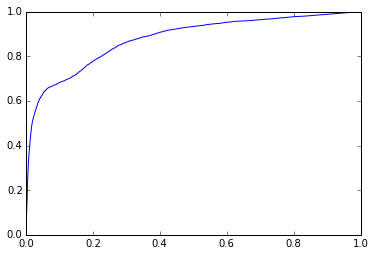

In [64]:
results = model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv.remove_column('tfidf_hashed17')

In [57]:
svm_model = gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=features + ['tfidf_hashed'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=15)

PROGRESS: SVM:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 269988
PROGRESS: Number of classes           : 2
PROGRESS: Number of feature columns   : 16
PROGRESS: Number of unpacked features : 65479
PROGRESS: Number of coefficients    : 65480
PROGRESS: Starting L-BFGS
PROGRESS: --------------------------------------------------------
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | Iteration | Passes   | Step size | Elapsed Time | Training-accuracy | Validation-accuracy |
PROGRESS: +-----------+----------+-----------+--------------+-------------------+---------------------+
PROGRESS: | 1         | 3        | 0.000004  | 3.007788     | 0.499826          | 0.490319            |
PROGRESS: | 2         | 5        | 1.000000  | 5.184788     | 0.930797          | 0.919983            |
PROGRESS: | 3         | 6        | 1.000000  | 6.704534     | 0.922900          | 0

In [60]:
svm_model

Class                         : SVMClassifier

Schema
------
Number of coefficients        : 65480
Number of examples            : 269988
Number of classes             : 2
Number of feature columns     : 16
Number of unpacked features   : 65479

Hyperparameters
---------------
Mis-classification penalty    : 1.0

Training Summary
----------------
Solver                        : auto
Solver iterations             : 15
Solver status                 : TERMINATED: Iteration limit reached.
Training time (sec)           : 26.2553

Settings
--------
Train Loss                    : 10182.9826

Highest Positive Coefficients
-----------------------------
tfidf_hashed[32859]           : 0.6915
tfidf_hashed[7681]            : 0.4172
tfidf_hashed[6147]            : 0.3726
tfidf_hashed[51081]           : 0.3615
tfidf_hashed[24142]           : 0.3589

Lowest Negative Coefficients
----------------------------
tfidf_hashed[52880]           : -0.4636
(intercept)                   : -0.439
tfidf_hashed[8

In [58]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']].sort('margin')
train_cv.remove_column('margin')

pd_preds = preds.to_dataframe()
pd_preds['number'] = 1.0

pd_preds_cum = pd_preds.cumsum()

total_positives = np.asarray(pd_preds_cum['sponsored'])[-1]
total = np.asarray(pd_preds_cum['number'])[-1]
total_negatives = total - total_positives

pd_preds_cum['FN'] = pd_preds_cum['sponsored']
pd_preds_cum['TN'] = pd_preds_cum['number'] - pd_preds_cum['sponsored']

pd_preds_cum['TP'] = total_positives - pd_preds_cum['FN']
pd_preds_cum['FP'] = total - total_positives - pd_preds_cum['TN']

pd_preds_cum['fpr'] = pd_preds_cum['FP'] / (pd_preds_cum['FP'] + pd_preds_cum['TN'])
pd_preds_cum['tpr'] = pd_preds_cum['TP'] / (pd_preds_cum['TP'] + pd_preds_cum['FN'])



AUC = 0.894249


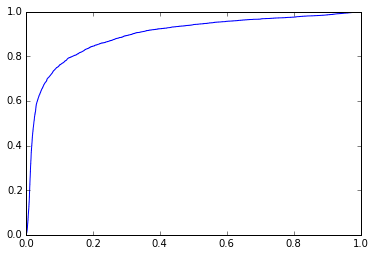

In [59]:
a = pd_preds_cum

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
train_cv['margin'] = svm_model.predict(train_cv, output_type='margin')
preds = train_cv[['sponsored', 'margin']]
preds['margin'].show()

In [ ]:
(preds[preds['margin'] < 55]['sponsored']).sum()

In [ ]:
ts = np.arange(-22, 50, 0.1)
[for t in ts]

In [ ]:
svm_model.evaluate(train_cv)

In [ ]:
results = svm_model.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
results

# Save Datasets?

In [ ]:
train_train.save('dataset_train_train')
train_cv.save('dataset_train_cv')
test.save('dataset_test')

# Junk

In [ ]:
hash_encoder = gl.feature_engineering.create(train_train, FeatureHasher(features = ['tfidf'], num_bits=17, 
                                                                  output_column_name='tfidf_hashed_17'))
train_train['tfidf_hashed_17'] = hash_encoder.transform(train_train)['tfidf_hashed_17']
train_cv['tfidf_hashed_17'] = hash_encoder.transform(train_cv)['tfidf_hashed_17']

In [ ]:
train_train.head()

In [ ]:
model_15 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=40,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_15

In [ ]:
model_15.evaluate(train_cv)

In [ ]:
results = model_15.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_16 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,
                                      class_weights='auto',
                                      max_iterations=20,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_16.evaluate(train_cv)

In [ ]:
results = model_16.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=8,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17 = gl.logistic_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,
                                      class_weights=None, #'auto',
                                      max_iterations=7,
                                      feature_rescaling=True,
                                      l2_penalty=0.00,
                                      l1_penalty=0.00)

In [ ]:
model_17.evaluate(train_cv)

In [ ]:
results = model_17.evaluate(train_cv, metric='roc_curve')
a = results['roc_curve']

fpr = list(a['fpr'])
tpr = list(a['tpr'])
fpr[0] = 1.0
tpr[0] = 1.0
fpr = np.array(fpr)
tpr = np.array(tpr)

AUC = np.sum((fpr[:-1] - fpr[1:]) * (tpr[:-1] + (tpr[:-1] - tpr[1:])/2))
plt.plot(fpr, tpr)
print('AUC = %f'%AUC)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_15'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_16'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
gl.svm_classifier.create(train_train, target='sponsored', 
                                      features=['tfidf_hashed_17'],
                                      validation_set=train_cv,                                           
                                      class_weights='auto',
                                      max_iterations=40)

In [ ]:
train.head()

In [ ]:
train.save('tfidf_hashed_16_train')
test.save('tfidf_hashed_16_test')

In [ ]:
train_train.save('tfidf_hashed_16_split_train_train')
train_cv.save('tfidf_hashed_16_split_train_cv')